In [1]:
%pylab
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr, entropy, pearsonr
import scipy.io as spio
import statsmodels.formula.api as sm
import sys, csv, pingouin
import os
import quickHTML as qh
import matplotlib.pyplot as plt

######################
## HELPER FUNCTIONS ##
######################

#Functions to creat labels
def trial_label(x):
    as_strings = [num.astype(str) for num in x]
    return "".join(as_strings)

def make_features(trials_data):
    labeled_data = np.apply_along_axis(trial_label, 0, trials_data)
    combos = np.unique(labeled_data)
    string_to_index = dict(zip(combos, np.arange(len(combos))))
    map_to_index = np.vectorize(lambda x: string_to_index[x])
    mapped_data = map_to_index(labeled_data)
    return mapped_data

def get_marginal(x):
    """
    Helper function to compute and return marginal probability distribution for a 1d vector (x)
    """
    px = np.array([np.sum(x==xi) for xi in np.sort(np.unique(x))])/len(x)
    return(px)

def get_joint(x, y):
    """
    Computes joint probability distribution between 1d vectors x and y
    """
    #  set up dictionary for joint distribution (x-->y-->freq)
    joint_x_y = {}
    
    for x_un in np.unique(x):
        joint_x_y[x_un] = dict(zip(np.unique(y), np.zeros(len(np.unique(y)))))
        
#    populate dictionary 
    for trial, x_val in enumerate(x):
        y_val = y[trial]
        joint_x_y[x_val][y_val] += 1
        
#   normalize to make distirbution  
    joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
    
    for key1 in joint_x_y:
        for key2 in joint_x_y[key1]:
            joint_x_y[key1][key2] /= joint_sum
            
    return(joint_x_y)

def mutual_inf(x, y):
    """
    Calculates the mutual information I(x;y)
    Assuming x,y are both [n x 1] dimensional
    """  
#     Calculate marginal distributions
    px = get_marginal(x)
    py = get_marginal(y)
    
    
    joint_x_y = get_joint(x,y)
# calculate mutual information
    mi = 0
    
    for n_x, x_un in enumerate(np.unique(x)):
        pxi = px[n_x] # p(x)
        
        for n_y, y_un in enumerate(np.unique(y)):
            pyi = py[n_y] # p(y)            
            
            joint_i = joint_x_y[x_un][y_un] # P(x,y)
            
            if ((pxi == 0) or (pyi == 0) or (joint_i ==0 )):
                continue
            else:
                mi += joint_i * np.log2(joint_i/(pxi*pyi))
                
    return mi

Using matplotlib backend: <object object at 0x00000188510AAA90>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Raw Behavioral Data

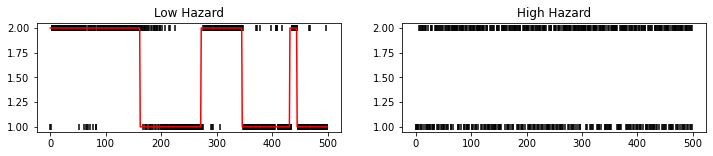

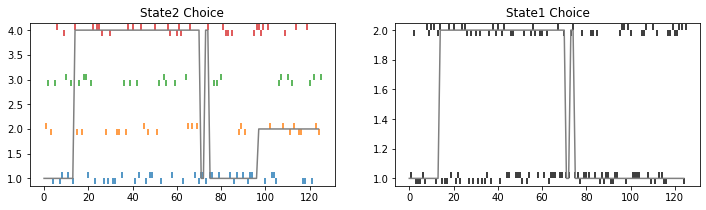

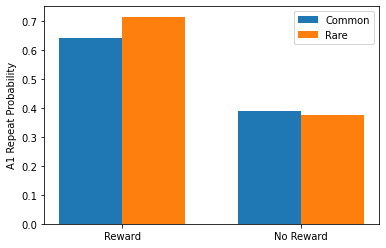

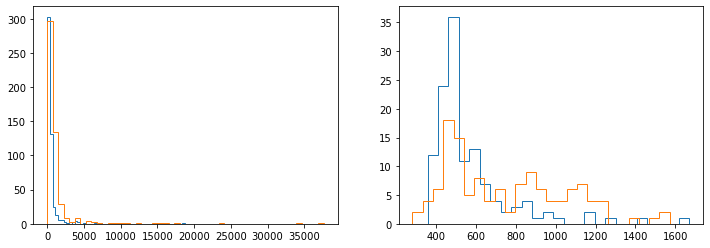

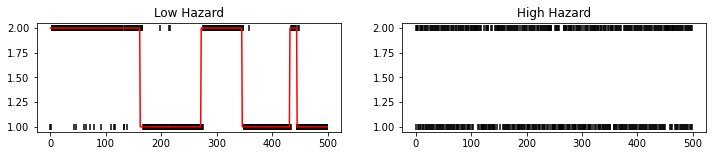

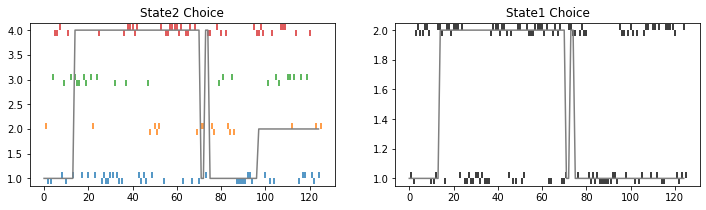

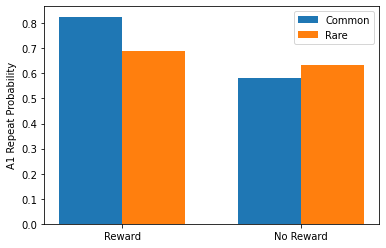

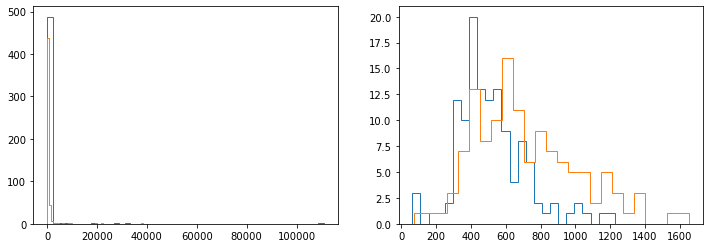

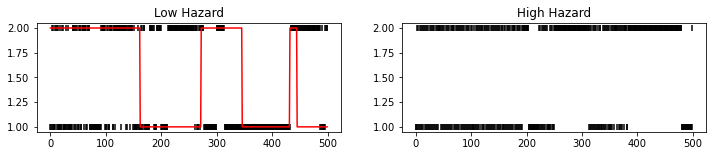

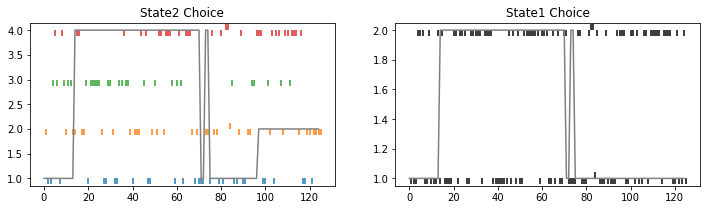

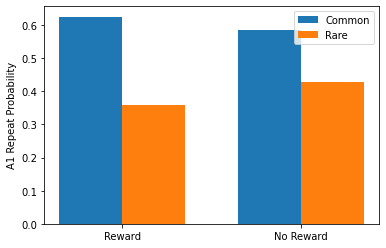

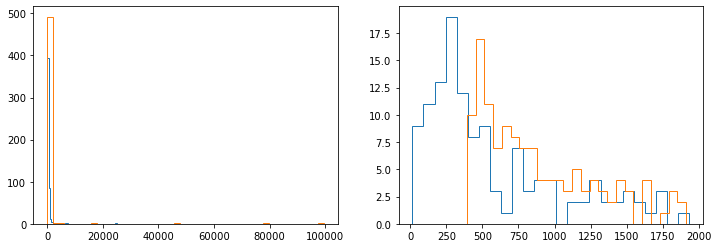

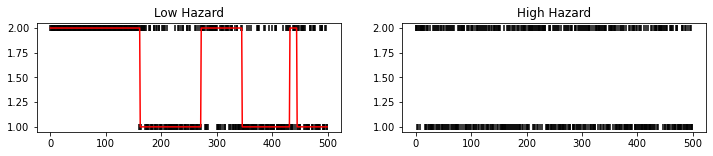

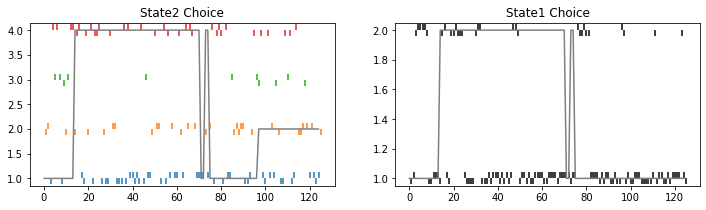

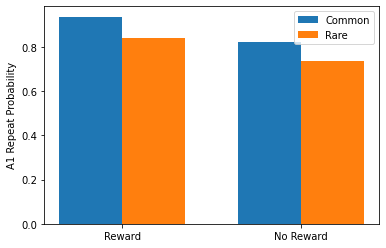

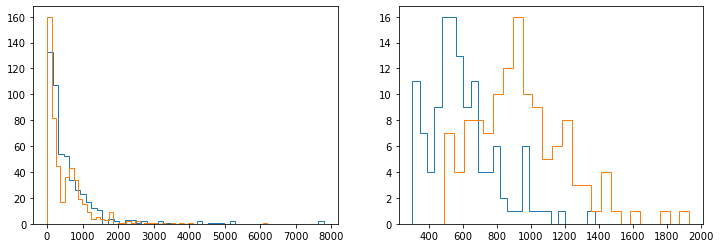

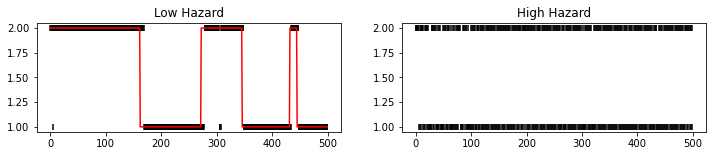

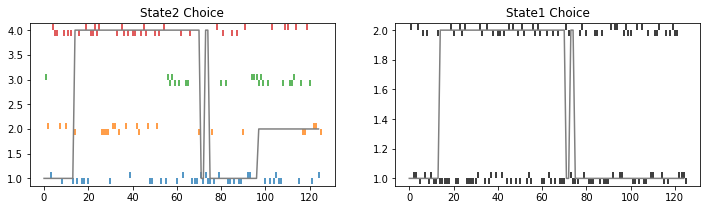

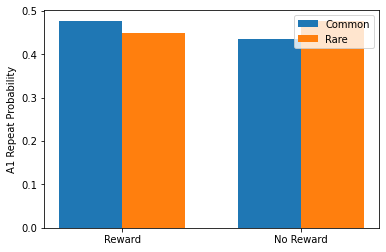

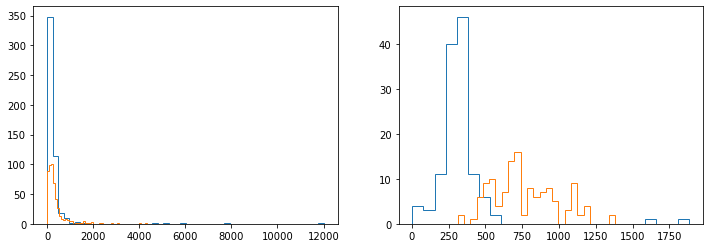

In [49]:
rootdir = 'C:\\Users\\parja\\Projects\\cross-domain-model-complexity\\'
datadir = rootdir + 'data\\pilot_2022-10-27\\'
arm_seq_df = pd.read_csv(rootdir + 'tasks\\two-arm-new\\stimuli\\seq8_new_new.csv')
sjfiles = [sjfile for sjfile in os.listdir(datadir) if '.csv' in sjfile]
sjkey = {}
sjbonus = {}
beads_scores = []
arm_scores = []
lowH_times = []
highH_times = []
arm_times = []
jj = 1
for sjfile in sjfiles:
    sjdf = pd.read_csv(datadir + sjfile)
    sjkey[jj] = sjdf.subject_id[0]
    sjbonus[jj] = sjdf.total_bonus[len(sjdf)-2]
    jj += 1
    
    beads_scores.append(int(sjdf.highH_score[np.isnan(sjdf.highH_score) == False]) + int(sjdf.lowH_score[np.isnan(sjdf.lowH_score) == False]))
    arm_scores.append(int(sjdf.two_arm_score[np.isnan(sjdf.two_arm_score) == False]))
    
    beads_exp_df = sjdf[(sjdf.block == 'highH') | (sjdf.block == 'lowH')]
    arm_exp_df = sjdf[sjdf.block == 'two_arm_exp']
    
    ltimes = beads_exp_df.time_elapsed[beads_exp_df.block == 'lowH'].to_numpy()
    htimes = beads_exp_df.time_elapsed[beads_exp_df.block == 'highH'].to_numpy()
    lowH_times.append((ltimes[-1] - ltimes[0])/1000/60)
    highH_times.append((htimes[-1] - htimes[0])/1000/60)
    
    atimes = arm_exp_df.time_elapsed.to_numpy()
    arm_times.append((atimes[-1] - atimes[0])/1000/60)
    
    fig1, axs1 = plt.subplots(1,2,figsize=(12, 2))
    axs1[0].plot(range(500),beads_exp_df.jar[sjdf.block == 'lowH'],color='r')
    axs1[0].scatter(range(500),beads_exp_df.choice[sjdf.block == 'lowH'],c='black',marker='|')
    axs1[0].set_title('Low Hazard')
    
    axs1[1].scatter(range(500),beads_exp_df.choice[sjdf.block == 'highH'],c='black',marker='|')
    axs1[1].set_title('High Hazard')
    
    mdict = {
        'f': 2,
        'j': 3
    }
    
    cdict = {
        1: 'tab:blue',
        2: 'tab:orange',
        3: 'tab:green',
        4: 'tab:red'
    }
    
    fig2, axs2 = plt.subplots(1,2,figsize=(12, 3))
    axs2[0].plot(range(125),np.array(arm_seq_df['S1_A_star'])+1,color='gray')
    for choice in unique(arm_exp_df.choice):
        axs2[0].scatter(arm_exp_df.trial_number[(arm_exp_df.choice == choice) & (arm_exp_df.state2_key == 'f')],
                      arm_exp_df.choice[(arm_exp_df.choice == choice) & (arm_exp_df.state2_key == 'f')],
                      marker=mdict['f'],
                       c=cdict[choice])
        axs2[0].scatter(arm_exp_df.trial_number[(arm_exp_df.choice == choice) & (arm_exp_df.state2_key == 'j')],
                      arm_exp_df.choice[(arm_exp_df.choice == choice) & (arm_exp_df.state2_key == 'j')],
                      marker=mdict['j'],
                       c=cdict[choice])
        
    axs2[1].plot(range(125),np.array(arm_seq_df['S0_A_star'])+1,color='gray')
    for action in unique(arm_exp_df.state1_action):
        axs2[1].scatter(arm_exp_df.trial_number[(arm_exp_df.state1_action == action) & (arm_exp_df.state2_key == 'f')],
                       arm_exp_df.state1_action[(arm_exp_df.state1_action == action) & (arm_exp_df.state2_key == 'f')],
                       marker=mdict['f'],
                       c='black')
        axs2[1].scatter(arm_exp_df.trial_number[(arm_exp_df.state1_action == action) & (arm_exp_df.state2_key == 'j')],
                       arm_exp_df.state1_action[(arm_exp_df.state1_action == action) & (arm_exp_df.state2_key == 'j')],
                       marker=mdict['j'],
                       c='black')
        
    axs2[0].set_title('State2 Choice')
    axs2[1].set_title('State1 Choice')
    
    arm_exp_df.reset_index(inplace=True)
    com_stay_rew = 0
    com_rew_total = 0
    rare_stay_rew = 0
    rare_rew_total = 0
    com_stay_norew = 0
    com_norew_total = 0
    rare_stay_norew = 0
    rare_norew_total = 0
    for t in range(1,len(arm_exp_df)):
        if arm_exp_df.state1_action[t-1] == arm_exp_df.state2_visited[t-1]:
            if arm_exp_df.rewarded[t-1] == 1:
                com_rew_total += 1
                if arm_exp_df.state1_action[t] == arm_exp_df.state1_action[t-1]:
                    com_stay_rew += 1
            else:
                com_norew_total += 1
                if arm_exp_df.state1_action[t] == arm_exp_df.state1_action[t-1]:
                    com_stay_norew += 1
        else:
            if arm_exp_df.rewarded[t-1] == 1:
                rare_rew_total += 1
                if arm_exp_df.state1_action[t] == arm_exp_df.state1_action[t-1]:
                    rare_stay_rew += 1
            else:
                rare_norew_total += 1
                if arm_exp_df.state1_action[t] == arm_exp_df.state1_action[t-1]:
                    rare_stay_norew += 1
    
    fig5, axs5 = plt.subplots()
    labels = ['Reward','No Reward']
    x = np.arange(len(labels))
    width = 0.35
    axs5.bar(x - width/2,[com_stay_rew/com_rew_total, com_stay_norew/com_norew_total],width,label='Common')
    axs5.bar(x + width/2,[rare_stay_rew/rare_rew_total, rare_stay_norew/rare_norew_total],width,label='Rare')
    axs5.set_xticks(x,labels)
    axs5.legend()
    axs5.set_ylabel('A1 Repeat Probability')
    
    fig3, axs3 = plt.subplots(1,2,figsize=(12,4))
    axs3[0].hist(beads_exp_df.rt[sjdf.block == 'lowH'],50,histtype='step')
    axs3[0].hist(beads_exp_df.rt[sjdf.block == 'highH'],50,histtype='step')
    
    axs3[1].hist(arm_exp_df.state1_rt,25,histtype='step')
    axs3[1].hist(arm_exp_df.state2_rt,25,histtype='step')
    

In [52]:
for sj in sjkey:
    print(sjkey[sj] + ',' + str(sjbonus[sj]))
    
sjinds = [0,1,3,4]
print(beads_scores)
print(arm_scores)
print(np.mean(np.array(beads_scores)[sjinds]))
print(np.mean(np.array(arm_scores)[sjinds]))
print(lowH_times)
print(highH_times)
print(arm_times)
print(np.mean(np.array(lowH_times)[sjinds]))
print(np.mean(np.array(highH_times)[sjinds]))
print(np.mean(np.array(arm_times)[sjinds]))

5e4898bd88257233536a65b5,1.25
603595f7c81d8e6ceaa65476,1.33
5c35132e48ad2900017e535e,1.12
6102c843811b2ec9d92767ad,1.2200000000000002
60d2d061fd054556769ca306,1.37
[609, 701, 498, 557, 727]
[64, 62, 62, 66, 64]
648.5
64.0
[11.494683333333334, 12.9932, 10.216849999999999, 11.963533333333334, 9.0101]
[17.18055, 12.00745, 13.257333333333333, 11.043883333333333, 9.700366666666667]
[7.011666666666667, 6.7412, 9.723566666666667, 7.5027, 6.5460666666666665]
11.365379166666669
12.4830625
6.950408333333334


## Overall model complexity comparison (test code)

In [4]:
# Get trial info needed to compute complexity
#     R1 = np.array(sdat['R1'].loc[sdat['R1'] >= 0]-1)
#     S2 = np.array(sdat['S2'].loc[sdat['R1'] >= 0]-1)
#     Rw = np.array(sdat['Rw'].loc[sdat['R1'] >= 0])
#     R1_star = np.array(sdat['R1_star'].loc[sdat['R1'] >= 0]-1)
    
#     # Get first-step RT info
#     rt1 = np.array(sdat['rt1'].loc[sdat['R1'] >= 0])
    
#     # Compute complexity for different feature sizes
#     # All past features
#     all_stack = np.stack((R1,S2,Rw,R1_star),axis=1)
#     all_features = np.sum(all_stack*(2**np.arange(4)),axis=1)
#     subInfo[subID[i]]['Ipast_all'] = mutual_inf(all_features[:-1],R1[1:])

# compute model complexity for beads task

# get trial info (beads draws on previous 3 trials and hazard rate)
npb = 3 #number of past beads
task_info = np.empty(((500-npb)*2,npb+1))
task_info[:500-npb,0] = 0
task_info[500-npb:,0] = 1

bead_seq = np.concatenate((np.zeros((500)),np.array(beads_exp_df.bead[beads_exp_df.block == 'lowH'])))
bead_mat = np.zeros((500,500))
for ii in range(500):
    bead_mat[ii,:] = np.flipud(bead_seq[ii+1:ii+501])
past_beads = bead_mat[npb:,1:npb+1] - 1
task_info[:500-npb,1:] = past_beads

bead_seq = np.concatenate((np.zeros((500)),np.array(beads_exp_df.bead[beads_exp_df.block == 'highH'])))
bead_mat = np.zeros((500,500))
for ii in range(500):
    bead_mat[ii,:] = np.flipud(bead_seq[ii+1:ii+501])
past_beads = bead_mat[npb:,1:npb+1] - 1
task_info[500-npb:,1:] = past_beads

#combine task info features into one single feature, in this case with a binary encoding
task_info_all = np.sum(task_info*(2**np.arange(npb+1)),axis=1)

In [5]:
# get predictions
predictions = np.empty(((500-npb)*2))

pred_lowH = np.array(beads_exp_df.choice[beads_exp_df.block == 'lowH']) - 1
pred_lowH = pred_lowH[npb:]
pred_highH = np.array(beads_exp_df.choice[beads_exp_df.block == 'highH']) - 1
pred_highH = pred_highH[npb:]

predictions = np.concatenate((pred_lowH,pred_highH))

In [6]:
# compute model complexity
mc = mutual_inf(task_info_all,predictions)
print(mc)

0.5130589682149387


C:\Users\parja\AppData\Local\Temp\ipykernel_13620\2753200092.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))


In [7]:
# compute model complexity for two arm task

# get task info
A1_1 = np.array(arm_exp_df.state1_action)[:-1] - 1
Rw_1 = np.array(arm_exp_df.rewarded)[:-1]
S2_1 = np.array(arm_exp_df.state2_visited)[:-1] - 1
A1_star_1 = np.array(arm_seq_df.S0_A_star)[:-1]

task_info = np.stack((A1_1,Rw_1,S2_1,A1_star_1),axis=1)
task_info_all = np.sum(task_info*(2**np.arange(4)),axis=1)

# get action
A1_0 = np.array(arm_exp_df.state1_action)[1:] - 1

# compute model complexity
mc = mutual_inf(task_info_all,A1_0)
print(mc)

0.13879427294201152


C:\Users\parja\AppData\Local\Temp\ipykernel_13620\2753200092.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))


## Overall model complexity comparison

In [8]:
beads_mc = []
two_arm_mc = []
two_arm_mc2 = []
for sjfile in sjfiles:
    sjdf = pd.read_csv(datadir + sjfile)
    beads_exp_df = sjdf[(sjdf.block == 'highH') | (sjdf.block == 'lowH')]
    arm_exp_df = sjdf[sjdf.block == 'two_arm_exp']
    
    # beads
    
    npb = 3 #number of past beads
    task_info = np.empty(((500-npb)*2,npb+1))
    task_info[:500-npb,0] = 0
    task_info[500-npb:,0] = 1

    bead_seq = np.concatenate((np.zeros((500)),np.array(beads_exp_df.bead[beads_exp_df.block == 'lowH'])))
    bead_mat = np.zeros((500,500))
    for ii in range(500):
        bead_mat[ii,:] = np.flipud(bead_seq[ii+1:ii+501])
    past_beads = bead_mat[npb:,1:npb+1] - 1
    task_info[:500-npb,1:] = past_beads

    bead_seq = np.concatenate((np.zeros((500)),np.array(beads_exp_df.bead[beads_exp_df.block == 'highH'])))
    bead_mat = np.zeros((500,500))
    for ii in range(500):
        bead_mat[ii,:] = np.flipud(bead_seq[ii+1:ii+501])
    past_beads = bead_mat[npb:,1:npb+1] - 1
    task_info[500-npb:,1:] = past_beads

    #combine task info features into one single feature, in this case with a binary encoding
    task_info_all = np.sum(task_info*(2**np.arange(npb+1)),axis=1)
    
    predictions = np.empty(((500-npb)*2))

    pred_lowH = np.array(beads_exp_df.choice[beads_exp_df.block == 'lowH']) - 1
    pred_lowH = pred_lowH[npb:]
    pred_highH = np.array(beads_exp_df.choice[beads_exp_df.block == 'highH']) - 1
    pred_highH = pred_highH[npb:]

    predictions = np.concatenate((pred_lowH,pred_highH))
    
    #compute model complexity
    mc = mutual_inf(task_info_all,predictions)
    beads_mc.append(mc)
    
    # two-arm
    # get task info
    A1_1 = np.array(arm_exp_df.state1_action)[:-1] - 1
    Rw_1 = np.array(arm_exp_df.rewarded)[:-1]
    S2_1 = np.array(arm_exp_df.state2_visited)[:-1] - 1
    A1_star_1 = np.array(arm_seq_df.S0_A_star)[:-1]

    task_info = np.stack((A1_1,Rw_1,S2_1,A1_star_1),axis=1)
    task_info_all = np.sum(task_info*(2**np.arange(4)),axis=1)

    # get actions
    A1_0 = np.array(arm_exp_df.state1_action)[1:] - 1

    # compute model complexity
    mc = mutual_inf(task_info_all,A1_0)
    two_arm_mc.append(mc)
    
    # two arm, but with different variables
    # get task info, trial t-1 and t-2
    task_info1 = np.stack((Rw_1,A1_1),axis=1)
    task_info2 = task_info1[:-1,:]
    task_info1 = task_info1[1:,:]
    task_info = np.hstack((task_info1,task_info2))
    task_info_all = np.sum(task_info*(2**np.arange(4)),axis=1)
    
    # get actions
    A1_0 = A1_0[1:]
    
    # compute model complexity
    mc = mutual_inf(task_info_all,A1_0)
    two_arm_mc2.append(mc)

C:\Users\parja\AppData\Local\Temp\ipykernel_13620\2753200092.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
C:\Users\parja\AppData\Local\Temp\ipykernel_13620\2753200092.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
C:\Users\parja\AppData\Local\Temp\ipykernel_13620\2753200092.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
C:\Users\parja\AppData\Local\Temp\

In [9]:
task_info[:15]

array([[0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 1.],
       [0., 1., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 1., 0.],
       [0., 0., 1., 1.],
       [1., 0., 0., 0.],
       [1., 0., 1., 0.]])

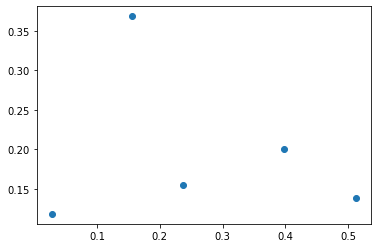

In [10]:
fig4, axs4 = plt.subplots()
axs4.scatter(beads_mc,two_arm_mc)

In [11]:
def encode_task_variables(df,feat_list,t_arr):
    # Inputs:
    #    df: dataframe with task variables
    #    feat_list: list of feature names corresponding to dataframe column headers
    #    t_arr: array of timepoints relative to current trial for each feature
    #    labels: a list of labels for each feature
    #
    # Outputs:
    #    feat_arr: a numpy array of the features encoded into a single value per time point
    assert len(feat_list) == len(t_arr)
    assert len(t_arr) == len(labels)
    
    depth = np.min(t_arr)
    feat_arr = np.zeros((len(df)-depth))
    for f in range(len(feat_list)):
        temp_arr = df[feat_list[f]]
        temp_arr = temp_arr[depth+t_arr[f]:]
        if (np.max(temp_arr) == 2) & (np.min(temp_arr) == 1):
            temp_arr = temp_arr - 1
        feat_arr = feat_arr + (temp_arr*(2**f))

beads_exp_df['hazard'] = 0
beads_exp_df.hazard[beads_exp_df.block == 'highH'] = 1
task_feat1 = encode_task_variables(beads_exp_df[beads_exp_df.block == 'lowH'],['hazard','bead','bead','bead'],np.array([0]))
= encode_task_variables(beads_exp_df[beads_exp_df.block == 'lowH'],['hazard','bead','bead','bead'],np.array([0]))

SyntaxError: invalid syntax (3254567675.py, line 25)

In [ ]:
A1_1

In [43]:
lowH_times = beads_exp_df.time_elapsed[beads_exp_df.block == 'lowH'].to_numpy()

In [44]:
lowH_times[0] - lowH_times[-1]

-540606

In [45]:
lowH_times

array([262729, 268748, 270426, 272169, 273772, 282454, 284669, 286002,
       287126, 288304, 289404, 290526, 291599, 292715, 293801, 294873,
       296642, 297855, 298963, 300063, 301181, 302286, 303339, 304439,
       305480, 306539, 307470, 308325, 309781, 311086, 312430, 313747,
       314690, 315900, 317076, 317979, 319265, 320131, 321325, 322550,
       323557, 324814, 325968, 326849, 328071, 329143, 330494, 331706,
       332930, 334066, 334936, 335917, 336852, 338155, 339082, 340404,
       341643, 342592, 343782, 344610, 345846, 347121, 348364, 349297,
       350242, 351429, 352659, 353542, 354831, 356072, 356907, 358076,
       359146, 360326, 361363, 362601, 363750, 364616, 365799, 367075,
       368271, 369434, 370277, 371107, 372092, 373041, 374019, 374986,
       375886, 376742, 377752, 379014, 380023, 381217, 382270, 383389,
       384431, 385453, 386632, 387735, 388821, 389928, 391234, 392271,
       393769, 395038, 396114, 397214, 398409, 399625, 400524, 401749,
      

In [46]:
lowH_times[-1]

803335

In [47]:
(lowH_times[-1] - lowH_times[0])/1000

540.606

In [48]:
(lowH_times[-1] - lowH_times[0])/1000/60

9.0101